In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm

In [2]:
def forward(V, A, B, init_dist):
    alpha = np.zeros((V.shape[0], A.shape[0]))
    alpha[0, :] = init_dist * B[:, V[0]]

    for t in range(1, V.shape[0]):
        for j in range(A.shape[0]):
            # matrix computation steps
            alpha[t, j] = alpha[t - 1] @ A[:, j] * B[j, V[t]]
    return alpha

In [4]:
def backward(V, A, B):
    beta = np.zeros((V.shape[0], A.shape[0]))

    # setting beta(T) = 1
    beta[V.shape[0] - 1] = np.ones((A.shape[0]))
    
    # loop in backawrd way fro T-1 to
    # actual loop T-2 to 0 (python indexing)
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(A.shape[0]):
            beta[t, j] = (beta[t + 1] * B[:, V[t + 1]]) @ A[j, :]
    return beta

In [5]:
def baum_welch(V, A, B, init_dist, n_iter=100):
    M = A.shape[0]
    T = len(V)
    for n in range(n_iter):
        # estimation
        alpha = forward(V, A, B, init_dist)
        beta = backward(V, A, B)

        xi = np.zeros((M, M, T -1))
        for t in range(T - 1):
            # joint prob of observed data up to time t @ transistion prob * close prob as t+1 #
            # joint prob of observed data from time t+1
            denominator = (alpha[t, :].T @ A * B[:, V[t + 1]].T) @ beta[t + 1, :]
            for i in range(M):
                numerator = alpha[t, i] * A[i, :] * B[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator
                
        gamma = np.sum(xi, axis=1)
        ## maximization step
        A = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
        
        # add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))
        
        K = B.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            B[:, l] = np.sum(gamma[:, V == 1], axis=1)
        
        B = np.divide(B, denominator.reshape((-1, 1)))
    return A, B

In [138]:
# where A is a day the stock closes high
# where B is a day the stock closes lower


ticker = 'aapl'
bartime = '1_day'

data = pd.read_csv('data/formatted/'+ticker +'/'+ticker+'_'+bartime+'_data_formatted.csv')

V = data['Visible'].values

# transistionn probabilities
A = np.ones((2, 2))
A = A / np.sum(A, axis=1)

# emmision probabilities
B = np.array(((1, 3, 5), (2, 4, 6)))
B = B / np.sum(B, axis=1).reshape((-1, 1))

# equal probabilities for the initial distribution
init_dist = np.arraay((0.5, 0.5))

n_iter = 100

a_model, b_model = baum_welch(V.copy(), A.copy(), B.copy(), init_dist.copy(), n_iter=n_iter)
print(f'Custom model A is \n{a_model} \n \nCustom model B is \n{b_model}')

FileNotFoundError: [Errno 2] No such file or directory: 'data/formatted/aapl/aapl_1_day_data_formatted.csv'

In [30]:
from datetime import datetime
ticker = 'aapl'
bartime = '1_day'

data = pd.read_csv('data/formatted/'+ticker +'/'+ticker+'_'+bartime+'_data_formatted1.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] >= datetime(2022,1,1)]
# Use the daily change in gold price as the observed measurements X.
X = data[["frac", "fracHigh", 'fracLow']].values
# Build the HMM model and fit to the gold price change data.
model = hmm.GMMHMM(n_components=4, n_mix=5, covariance_type='diag', algorithm='map', n_iter=50)
#model = hmm.GaussianHMM(n_components=3, covariance_type='diag', n_iter=50, random_state=42)
model.fit(X)


In [21]:
mus = np.ravel(model.means_)
sigmas = np.ravel(np.sqrt([np.diag(c) for c in model.covars_]))
P = model.transmat_

In [22]:
mus, sigmas

(array([-0.00097607,  0.00633874,  0.00954233,  0.02270028,  0.02996964,
         0.00153333,  0.00765781,  0.01214655,  0.00930795,  0.01265985,
         0.01504232,  0.00584332,  0.00051106,  0.0150246 ,  0.00522944,
        -0.03114459,  0.00461514,  0.03891249, -0.00636369,  0.00673624,
         0.01486101, -0.02052167,  0.00576056,  0.0253592 , -0.00150041,
         0.01670008,  0.01785331, -0.01499147,  0.0026931 ,  0.01903992,
         0.00262125,  0.00842143,  0.00247449,  0.01367419,  0.01633276,
         0.00141065,  0.00019386,  0.00483611,  0.00614406,  0.00803846,
         0.00973076,  0.00317381, -0.00770635,  0.00303558,  0.01191297,
         0.02982582,  0.03219572,  0.00798509,  0.03513165,  0.03742329,
         0.00147377,  0.01064343,  0.01496689,  0.0015771 ,  0.0183992 ,
         0.02196445,  0.00413292,  0.05225697,  0.05981192,  0.00334742]),
 array([0.00398459, 0.00331113, 0.00307748, 0.00858344, 0.00393862,
        0.0027658 , 0.00177811, 0.00318036, 0.00191489

In [23]:
P

array([[2.84609519e-01, 4.41900366e-01, 9.75394201e-02, 1.75950695e-01],
       [3.13115899e-01, 4.91545819e-01, 1.16812216e-04, 1.95221471e-01],
       [3.43347367e-02, 3.80227149e-02, 9.27642548e-01, 2.04783048e-11],
       [5.80573138e-01, 2.16155784e-01, 1.34839879e-15, 2.03271078e-01]])

In [32]:
import pickle

In [34]:
model = pickle.load(open('model_v2.pkl', 'rb'))

In [35]:
_, hidden_states = model.decode(X)

s = pd.Series(hidden_states).value_counts().sort_index()
s / s.sum()

0    0.263458
1    0.277325
2    0.336052
3    0.123165
Name: count, dtype: float64

In [36]:
# guassian dist means
print('Guassian Distribution Means:\n')
print(model.means_)

Guassian Distribution Means:

[[[-0.00097607  0.00633874  0.00954233]
  [ 0.02270028  0.02996964  0.00153333]
  [ 0.00765781  0.01214655  0.00930795]
  [ 0.01265985  0.01504232  0.00584332]
  [ 0.00051106  0.0150246   0.00522944]]

 [[-0.03114459  0.00461514  0.03891249]
  [-0.00636369  0.00673624  0.01486101]
  [-0.02052167  0.00576056  0.0253592 ]
  [-0.00150041  0.01670008  0.01785331]
  [-0.01499147  0.0026931   0.01903992]]

 [[ 0.00262125  0.00842143  0.00247449]
  [ 0.01367419  0.01633276  0.00141065]
  [ 0.00019386  0.00483611  0.00614406]
  [ 0.00803846  0.00973076  0.00317381]
  [-0.00770635  0.00303558  0.01191297]]

 [[ 0.02982582  0.03219572  0.00798509]
  [ 0.03513165  0.03742329  0.00147377]
  [ 0.01064343  0.01496689  0.0015771 ]
  [ 0.0183992   0.02196445  0.00413292]
  [ 0.05225697  0.05981192  0.00334742]]]


In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 10))
for i in (0,1,2,3):
    want = (hidden_states == i)
    x = data["date"].iloc[want]
    y = data["close"].iloc[want]
    plt.plot(x, y, '.')
plt.legend((0,1,2,3), fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("close price $", fontsize=16)
plt.xticks([])
plt.show()

NameError: name 'hidden_states' is not defined

<Figure size 1500x1000 with 0 Axes>

In [27]:
import pickle

In [28]:
with open("model_v2.pkl", "wb") as file: pickle.dump(model, file)

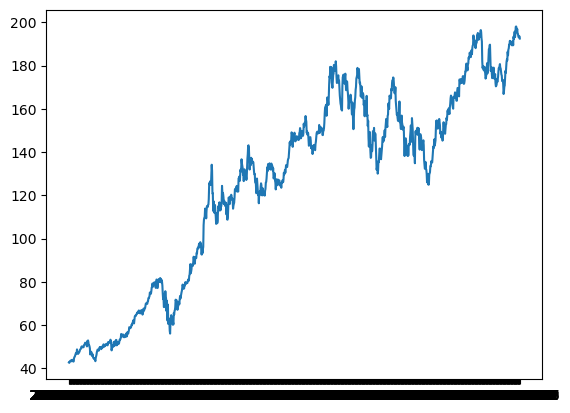

In [163]:
plt.plot(data['date'], data['close'])
plt.show()

In [ ]:
# compare to hmmlearn
model = hmm.MultinomialHMM(n_components=4, algorithm='map', n_iter=n_iter, int_params="", params="te", tol=0)
model.startprob_ = init_dist
model.transmat_ = A
model.emissionprob_ = B

model.fit([V])
print(f'hmmlearn A \n{model.transmat_}')
print(f'hmmlearn B \n{model.emissionprob_}')

In [ ]:
print(f'A difference example implementation and hmmlearn \n{a_model - (model.transmat_)}')
print(f'B difference example implementation and hmmlearn \n{b_model - (model.emissionprob_)}')
print(f'\nA example implementation and hmmlearn allclose: {np.allclose(a_model, model.transmat_, atol=0.1)}')
print(f'B example implementation and hmmlearn allclose: {np.allclose(b_model, model.emissionprob_, atol=0.1)}')